<div style="background-color:#BFBEBE; text-align: center;">
<img src="imgs/icon.png" style="width:600px">
</div>

# Analyzing and Hashing Audio Fingerprints

Princípios: 
* [Shazam](https://www.shazam.com/)
* [An Industrial-Strength Audio Search Algorithm](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)
* [A Fingerprint for Audio](https://medium.com/intrasonics/a-fingerprint-for-audio-3b337551a671)

`pip install youtube-downloader`

In [43]:
# import os
# import youtube_dl
# import subprocess
import numpy as np
# from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram
from IPython.display import Audio, display
from skimage.feature import peak_local_max
import librosa
from pydub import AudioSegment


plt.rcParams.update({'font.size': 18})

### Artist: Daft Punk
* Featured artists: Pharrell Williams, Nile Rodgers
* Album: Random Access Memories - Released: 2013
* Genre: Dance/Electronic

### Artist: Katy Perry
* Album: Gzone Rainbow Anthems - Released: 2016
* Nominations: Grammy Award for Record of the Year, MORE
* Genres: Dance/Electronic, Teen Pop, Rock, Pop

## Frequency Uncertainty

In [44]:
def beat_freq(f, max_time, rate):
    t = np.linspace(0, max_time, rate*max_time)
    signal = np.sin(2*np.pi*f*t)
    display(Audio(data=signal, rate=rate))
    return signal

def testarSom(filename):
    sound = AudioSegment.from_file(filename, format="wav")
    just=20
    print("channels:".ljust(just), sound.channels)
    # Number of bytes in each sample (1 means 8 bit, 2 means 16 bit, etc). CD Audio is 16 bit, (sample width of 2 bytes).
    print("sample_width:".ljust(just), sound.sample_width) 
    # CD Audio has a 44.1kHz sample rate, which means frame_rate will be 44100 (same as sample rate, see frame_width). Common values are 44100 (CD), 48000 (DVD), 22050, 24000, 12000 and 11025.
    print("frame_rate:".ljust(just), sound.frame_rate)
    # Number of bytes for each "frame". A frame contains a sample for each channel (so for stereo you have 2 samples per frame, which are played simultaneously). frame_width is equal to channels * sample_width. For CD Audio it'll be 4 (2 channels times 2 bytes per sample).
    print("frame_width:".ljust(just), sound.frame_width)
    # A measure of loudness. Used to compute dBFS, which is what you should use in most cases. Loudness is logarithmic (rms is not), which makes dB a much more natural scale.
    print("measure of loudness:".ljust(just), sound.rms)
    # The highest amplitude of any sample in the AudioSegment. Useful for things like normalization (which is provided in pydub.effects.normalize).
    print("highest amplitude:".ljust(just), sound.max)

In [45]:
signal_250 = beat_freq(250.0, 1, 11025)
signal_275 = beat_freq(275.0, 1, 11025)
signal_300 = beat_freq(300.0, 1, 11025)

In [46]:
signals = np.hstack((signal_275+signal_300, signal_275+signal_250))

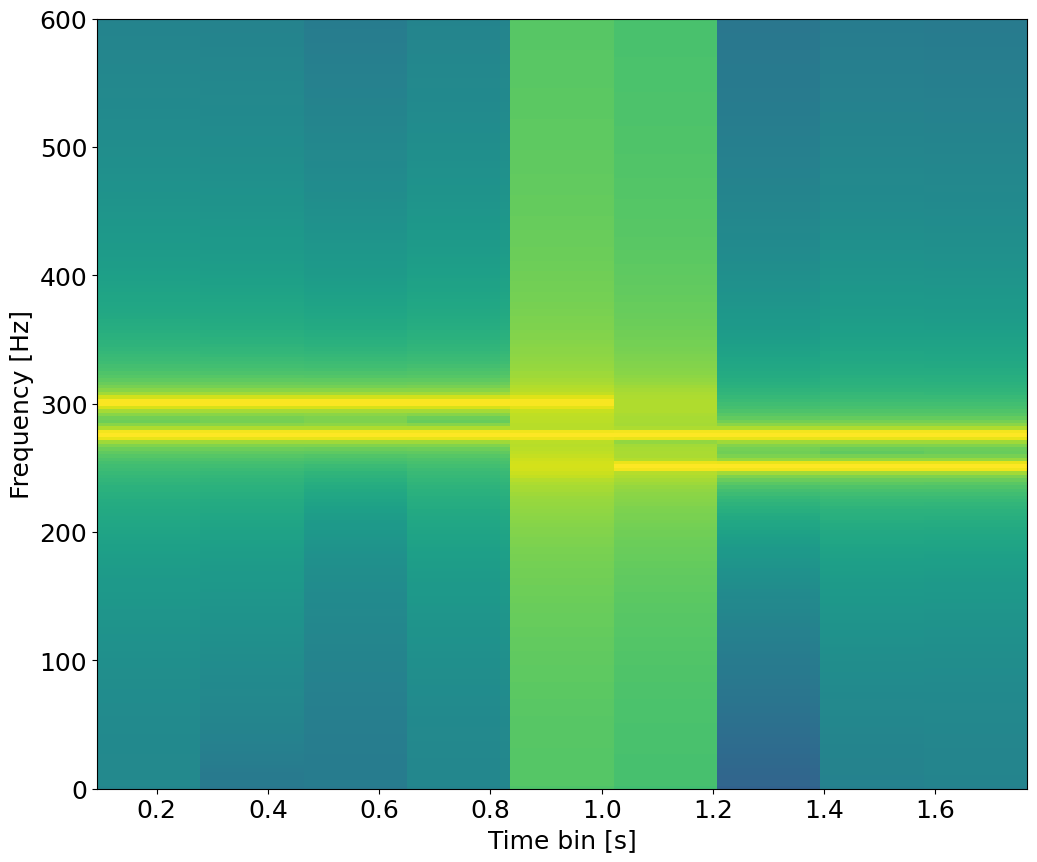

In [47]:
fig1 = plt.figure(figsize=(12, 10), facecolor='white')
plt.specgram(signals, NFFT=4096, Fs=11025, noverlap=2048, cmap='viridis')
ax1 = plt.gca()
ax1.set_ylim([0, 600])
plt.xlabel('Time bin [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

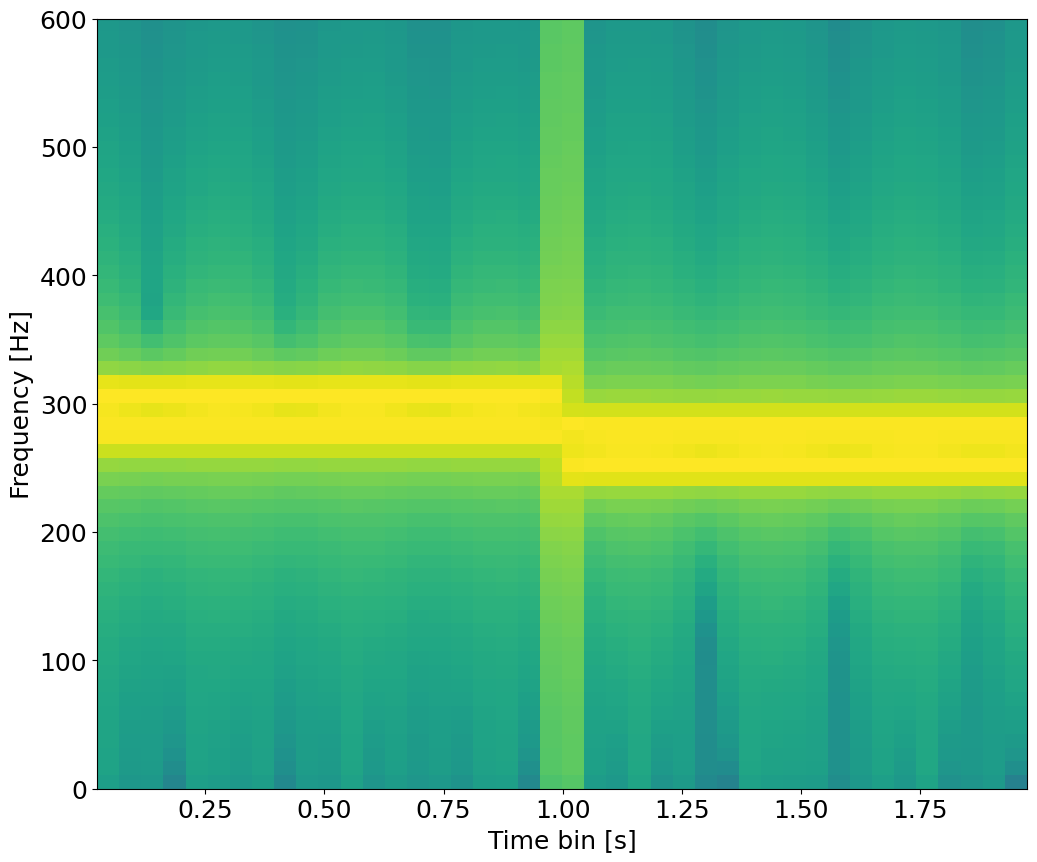

In [48]:
fig2 = plt.figure(figsize=(12, 10), facecolor='white')
plt.specgram(signals, NFFT=1024, Fs=11025, noverlap=512, cmap='viridis')
ax2 = plt.gca()
ax2.set_ylim([0, 600])
plt.xlabel('Time bin [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

# Harmonics

In [49]:
testarSom('audios/sax-phrase-t5.wav')

channels:            1
sample_width:        2
frame_rate:          44100
frame_width:         2
measure of loudness: 4705
highest amplitude:   16664


In [50]:
rate, song_array = wavfile.read('audios/sax-phrase-t5.wav')

In [51]:
def calc_specgram(song_array, NFFT, Fs, noverlap):
    spec, freqs, t = specgram(song_array, NFFT=NFFT, Fs=Fs, noverlap=noverlap)
    Z = 10.0 * np.log10(spec)
    Z = np.flipud(Z)
    extent = 0, len(t), freqs[0], freqs[-1]
    return Z, spec, freqs, t, extent

In [52]:
def show_specgram(Z, cmap, extent):
    fig = plt.figure(figsize=(22, 10), facecolor='white')
    plt.imshow(Z, cmap=cmap, extent=extent)
    plt.title('Sax Riff Mono')
    plt.xlabel('Time bin')
    plt.ylabel('Frequency [Hz]')
    plt.axis('auto')
    ax = plt.gca()
    ax.set_xlim([0, extent[1]])
    plt.show()

In [53]:
def cut_specgram(min_freq, max_freq, spec, freqs, t):
    spec_cut = spec[(freqs >= min_freq) & (freqs <= max_freq)]
    freqs_cut = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    Z_cut = 10.0 * np.log10(spec_cut)
    Z_cut = np.flipud(Z_cut)
    extent_cut = 0, len(t), freqs_cut[0], freqs_cut[-1]
    return Z_cut, spec_cut, freqs_cut, extent_cut

In [54]:
Z, spec, freqs, t, extent = calc_specgram(song_array, 4096, rate, 2048)

In [55]:
Z_cut, spec_cut, freqs_cut, extent_cut = cut_specgram(0, 4000, spec, freqs, t)

In [56]:
display(Audio(data=song_array, rate=rate))

In [57]:
extent_cut = extent = 0, len(t), freqs_cut[0], freqs_cut[-1]

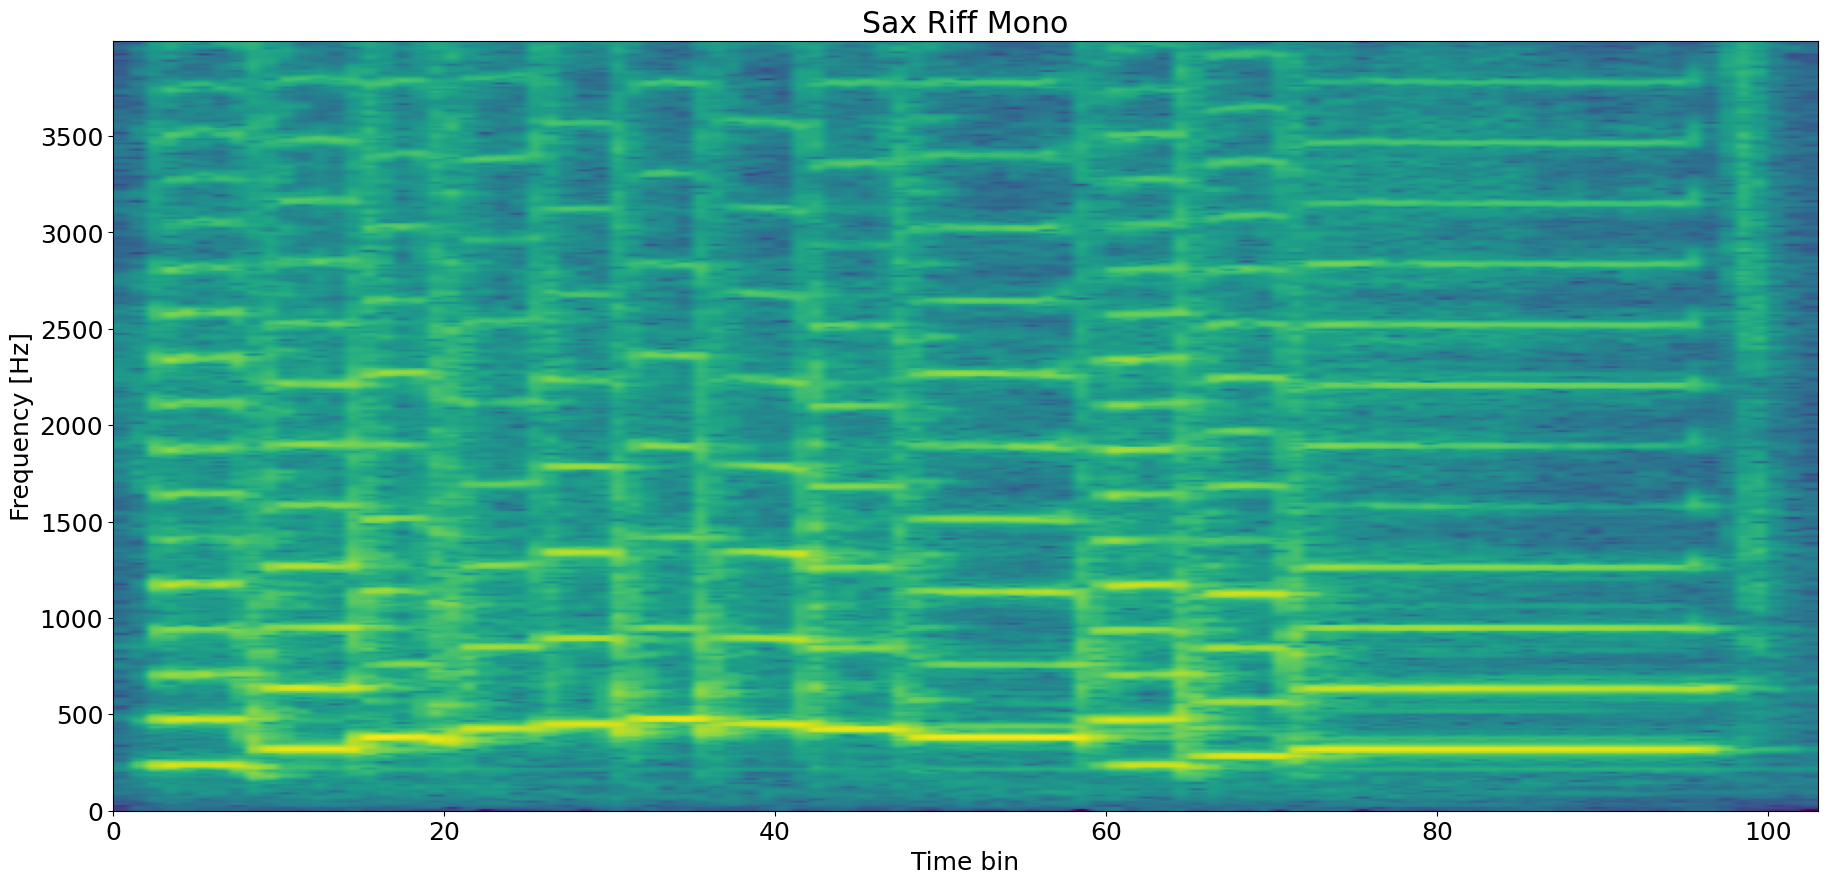

In [58]:
show_specgram(Z_cut, 'viridis', extent_cut)

## Song Fingerprinting

In [59]:
testarSom('audios/Firework-Katy Perry.wav')

channels:            2
sample_width:        2
frame_rate:          44100
frame_width:         4
measure of loudness: 8048
highest amplitude:   32768


In [60]:
testarSom('audios/Get Lucky-Nile Rodgers-Daft Punk.wav')

channels:            2
sample_width:        2
frame_rate:          44100
frame_width:         4
measure of loudness: 8141
highest amplitude:   32768


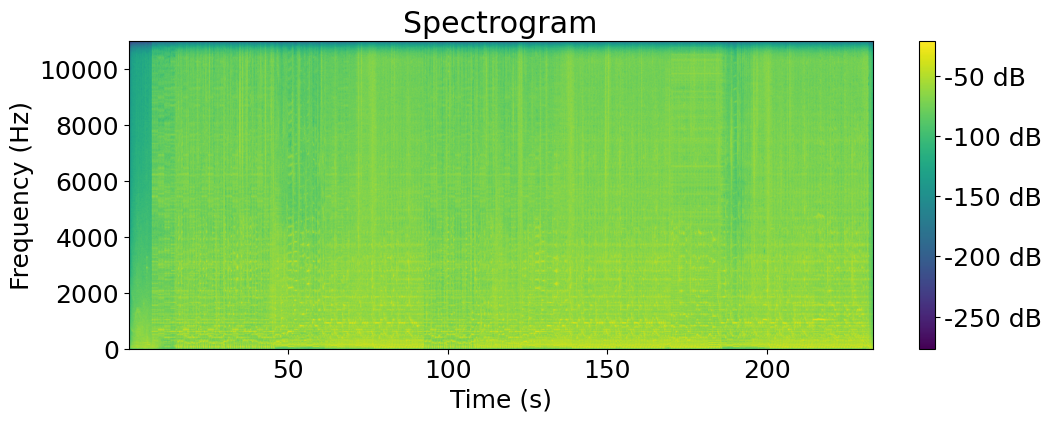

In [61]:
# Carregar o arquivo de áudio
y, sr = librosa.load('audios/Firework-Katy Perry.wav')

# Calcular o espectograma
spec, freqs, t = specgram(x=y, Fs=sr, NFFT=2048, noverlap=1024)

# Converter para escala logarítmica
log_specgram = 10 * np.log10(spec)

# Plotar o espectograma
plt.figure(figsize=(12, 4))
plt.imshow(log_specgram, origin='lower', extent=[t[0], t[-1], freqs[0], freqs[-1]], aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

/tmp/ipykernel_9930/102296249.py:8: RuntimeWarning: divide by zero encountered in log10
  log_specgram = 10 * np.log10(spec)


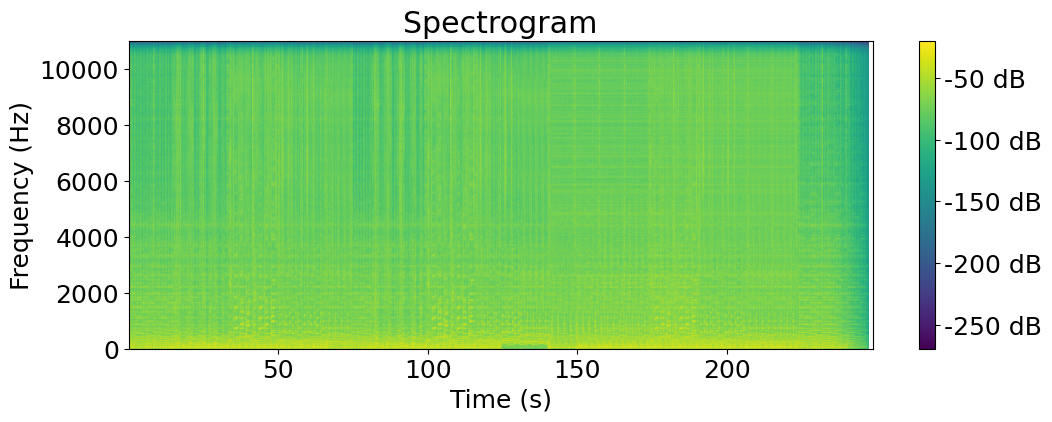

In [62]:
# Carregar o arquivo de áudio
y, sr = librosa.load('audios/Get Lucky-Nile Rodgers-Daft Punk.wav')

# Calcular o espectograma
spec, freqs, t = specgram(x=y, Fs=sr, NFFT=2048, noverlap=1024)

# Converter para escala logarítmica
log_specgram = 10 * np.log10(spec)

# Plotar o espectograma
plt.figure(figsize=(12, 4))
plt.imshow(log_specgram, origin='lower', extent=[t[0], t[-1], freqs[0], freqs[-1]], aspect='auto', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

In [66]:
rate1, song_array1 = wavfile.read('audios/Firework-Katy Perry.wav')
rate2, song_array2 = wavfile.read('audios/Get Lucky-Nile Rodgers-Daft Punk.wav')

In [67]:
spec1, freqs1, t1 = specgram(x=song_array1, NFFT=4096, Fs=rate1, noverlap=2048)
spec2, freqs2, t2 = specgram(x=song_array2, NFFT=4096, Fs=rate2, noverlap=2048)

# Ensure the shapes are compatible for broadcasting
spec1 = np.reshape(spec1, (spec1.shape[0], -1))
spec2 = np.reshape(spec2, (spec2.shape[0], -1))

spec1[spec1 == 0] = 1e-6
spec2[spec2 == 0] = 1e-6

ValueError: operands could not be broadcast together with shapes (4096,2,5022) (4096,1) 

In [ ]:
spec1, freqs1, t1 = specgram(x=song_array1, NFFT=4096, Fs=rate1, noverlap=2048)
spec2, freqs2, t2 = specgram(x=song_array2, NFFT=4096, Fs=rate2, noverlap=2048)


spec1[spec1 == 0] = 1e-6
spec2[spec2 == 0] = 1e-6

In [ ]:
fig1 = plt.figure(figsize=(26, 10), facecolor='white')
extent = 0, np.amax(t1), freqs1[0], freqs1[-1]
Z = 10.0 * np.log10(spec1)
Z = np.flipud(Z)
plt.imshow(Z, cmap='viridis', extent=extent)
plt.xlabel('Time bin')
plt.ylabel('Frequency [Hz]')
plt.title('Katy Perry song')
plt.axis('auto')
ax = plt.gca()
ax.set_xlim([0, extent[1]])
ax.set_ylim([freqs1[0], freqs1[-1]])
plt.show()

In [ ]:
def cut_specgram(min_freq, max_freq, spec, freqs):
    spec_cut = spec[(freqs >= min_freq) & (freqs <= max_freq)]
    freqs_cut = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    Z_cut = 10.0 * np.log10(spec_cut)
    Z_cut = np.flipud(Z_cut)
    return Z_cut, freqs_cut

In [ ]:
def show_peaks(Z, freqs, t, coord, title):
    fig = plt.figure(figsize=(26, 10), facecolor='white')
    plt.imshow(Z, cmap='viridis')
    plt.scatter(coord[:, 1], coord[:, 0])
    ax = plt.gca()
    plt.xlabel('Time bin')
    plt.ylabel('Frequency')
    plt.title(title, fontsize=18)
    plt.axis('auto')
    ax.set_xlim([0, len(t)])
    ax.set_ylim([len(freqs), 0])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.show()

In [ ]:
min_freq = 0
max_freq = 15000

Z1, freqs1 = cut_specgram(min_freq, max_freq, spec1, freqs1)
Z2, freqs2 = cut_specgram(min_freq, max_freq, spec2, freqs2)

In [ ]:
coordinates1 = peak_local_max(Z1, min_distance=20, threshold_abs=20)
coordinates2 = peak_local_max(Z2, min_distance=20, threshold_abs=20)

In [ ]:
show_peaks(Z1, freqs1, t1, coordinates1, 'Katy Perry song')

In [ ]:
show_peaks(Z2, freqs2, t2, coordinates2, 'Daft Punk song')